# 📝 Pattern Recognition & Biometrics. TP Traitement du Langage Naturel ou *NLP (Natural Language Processing)*

Par Omar Galarraga et Sonia Garcia

In [1]:
import numpy as np

Dans ce travail pratique, nous constituerons un *pipeline* de traitement du langage naturel avec différents modèles pour analyser le chapitre I du roman "Le Petit Prince" d'Antoine de Saint-Exupéry

In [2]:
#Modifiez votre chemin d'accès si besoin
with open('lepetitprince_chap1.txt', encoding='utf-8') as f:
    sentences = f.readlines()

## Partie I. *Word embeddings* ou la modélisation des mots

Nous utiliserons les libraries *nltk* et *gensim* pour créer des modèles *word2vec*

* I.1) Convertissez le texte (phrases) en tokens
* I.2) Construisez un modèle *CBOW* et un *skip-gram* avec le corpus du livre


In [3]:
from gensim.models import Word2Vec
import nltk
nltk.download('punkt')

from nltk.tokenize import word_tokenize
tokenized_sentences = [word_tokenize(sentence) for sentence in sentences]

w2v_cbow = Word2Vec(tokenized_sentences, vector_size=100, window=5, min_count=1, workers=4, sg=0)   #CBOW
w2v_sg = Word2Vec(tokenized_sentences, vector_size=100, window=5, min_count=1, workers=4, sg=1)     #Skip-gram




[nltk_data] Downloading package punkt to
[nltk_data]     /Users/linaelhaddaj/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


* I.3) Quel est le vecteur associé au mot "boa" ? Est-il le même dans les deux modèles (*CBOW* et *skip-gram*) ?
* I.4) Quels mots sont "similaires" au mot "boa" ? Sont-ils les mêmes dans les deux modèles ?

In [4]:
boa_cbow = w2v_cbow.wv['boa']
boa_sg = w2v_sg.wv['boa']

similarity = np.dot(boa_cbow, boa_sg) / (np.linalg.norm(boa_cbow) * np.linalg.norm(boa_sg))
print(f"Similarité entre {'boa avec CBOW'} et {'boa avec skip-gram'} : {similarity}")

Similarité entre boa avec CBOW et boa avec skip-gram : 0.9911510944366455


Pas le même mot mais quasiment le même (au vu de la similarité cosinus proche de 1)

In [5]:
similar_words_boa = w2v_cbow.wv.most_similar('boa')
print(similar_words_boa)

[('carrière', 0.2611195147037506), ('découragé', 0.2579665780067444), ('Chine', 0.2445865422487259), ('au', 0.22318489849567413), ('autre', 0.2174520343542099), ('amélioré', 0.19799430668354034), ('trop', 0.17396698892116547), ('vécu', 0.1704605221748352), ('peu', 0.16810756921768188), ('ne', 0.16546423733234406)]


* I.5) Affichez les graphiques des deux modèles en faisant une réduction de dimension à 2D par t-SNE (voir code d'exemple ci-dessous). Quelles sont les coordonnées en 2D du mot "boa" dans les deux modèles ?

/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


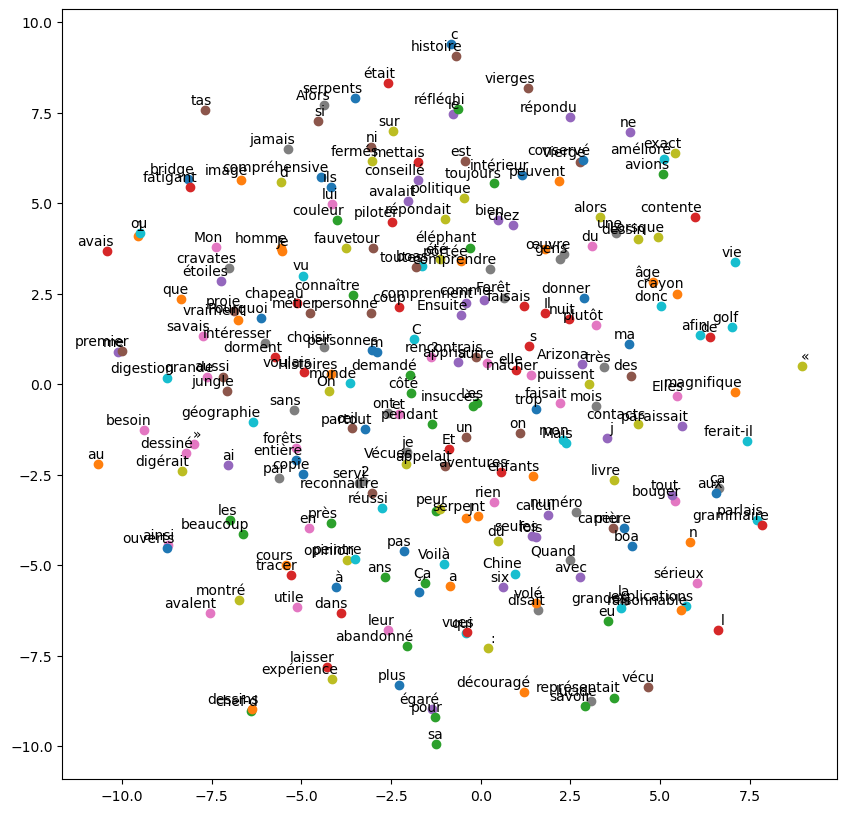

In [6]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Affectez le nom de votre modèle Word2Vec à la variable model_w2v ci-dessous
model_w2v = w2v_cbow

# t-SNE pour réduire à 2 dimensions
word_vectors = model_w2v.wv.vectors
num_samples = len(word_vectors)
tsne_perplexity = min(30, num_samples - 1)  # Perplexity must be less than the number of samples

tsne = TSNE(n_components=2, perplexity=tsne_perplexity, random_state=0)
word_vectors_2d = tsne.fit_transform(word_vectors)

# Plot the vectors
plt.figure(figsize=(10, 10))
for i, word in enumerate(model_w2v.wv.index_to_key):
    plt.scatter(word_vectors_2d[i, 0], word_vectors_2d[i, 1])
    plt.annotate(word, xy=(word_vectors_2d[i, 0], word_vectors_2d[i, 1]), xytext=(5, 2),
                 textcoords='offset points', ha='right', va='bottom')
plt.show()

In [7]:
boa_coord = word_vectors_2d[model_w2v.wv.key_to_index['boa']]
print(boa_coord)

[ 4.2261596 -4.4744782]


## Partie II. Réseaux de neurones et attention

* II.1) Construisez et entraînez un réseau de neurones dense pour prédire le cinquème token de chaque phrase en fonction des quatre premiers tokens d'un modèle Word2Vec. Quelle est l'erreur d'apprentissage ?
* II.2) Quelle est la dimension de la couche d'entrée ?
* II.3) Quelle est la dimension de la couche de sortie ?
* II.4) Quelle est l'erreur RMS pour la 10ème phrase ?


In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(400,)))





2024-05-17 12:20:48.475963: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/opt/anaconda3/lib/python3.9/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Partie III. Transformers


Pour cette partie, nous utiliserons le modèle *CamemBERT*, qui est modèle type BERT (Transformer) spécifique à la langue française. Ce modèle est disponible dans la librairie *Transformers* de *HuggingFace* (documentation disponible sur : https://huggingface.co/docs/transformers/model_doc/camembert). Nous travaillerons le fichier 'lepetitprince_chap1_masked.txt', qui contient des mots masqués.

* III.1) "Tokenisez" le texte. Quelle est la dimension du vecteur de modélisation des tokens ?

In [9]:
from transformers import CamembertTokenizer, CamembertModel

# Charger le tokenizer et le modèle CamemBERT
tokenizer = CamembertTokenizer.from_pretrained('camembert-base')
model = CamembertModel.from_pretrained('camembert-base')

# Tokeniser le texte
inputs = tokenizer('lepetitprince_chap1.txt', return_tensors='pt', max_length=512, truncation=True)

# Afficher les tokens
print(inputs)

# Déterminer la dimension du vecteur de modélisation des tokens
outputs = model(**inputs)
print("Dimension du vecteur de modélisation des tokens:", outputs.last_hidden_state.size())

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


{'input_ids': tensor([[    5,    16, 11194,  8458,  4795,   862, 27444,  5219,   110,   290,
           110,     6]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}


* III.2) Prédisez les mots masqués. Donnez les 3 mots les plus probables pour les 10 premières phrases.

In [ ]:
#Ecrivez votre code ici


## Partie IV. LLM

* IV.I) Réalisez à nouveau la partie III en utilisant cette fois-ci Llama2 ou Mixtral (modèles disponibles dans la librairie *Transformers* de *HuggingFace*). Llama2 est aussi téléchargeable sur https://llama-2.ai/download/
* IV.2) Faites un résumé automatique en 20 mots environ du chapitre I

In [ ]:
#Ecrivez votre code ici
